# Llama 3 Architecture Overview:

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/1*_xNP7aBpcmcMk4tXJ-Z8Mw.png' width='500'>

# Libs

In [72]:
import torch
from torch import nn
from torch.nn import functional as F

import requests
import math
import numpy as np
import time
from dataclasses import dataclass
from typing import Optional, Tuple, List
import pandas as pd
from matplotlib import pyplot as plt

# Load Data

In [73]:
# Load tiny_shakespeare data file.
url = 'https://raw.githubusercontent.com/tamangmilan/llama3/refs/heads/main/tiny_shakespeare.txt'
response = requests.get(url)
assert response.status_code == 200, f"Failed to retrieve file. Status code: {response.status_code}"

In [74]:
data = response.text

# The Input Block

The input block has 3 components: Texts/Prompts, Tokenizer and Embeddings.

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/1*7iKiOUpXAWUJ_vlVkWuC_w.png' width='500'>

- Each token-id will be transformed into an embedding vector of dimensions 128(in original Llama 3 8B, it is 4096).

- Using Tiny Shakespeare dataset for character-level tokenizer.

In [75]:
# Prepare vocabulary by taking all the unique characters from data
vocab = sorted(list(set(data)))

# Training Llama 3 model requires addtional tokens such as <|begin_of_text|>, <|end_of_text|> and <|pad_id|>
vocab += ['<|begin_of_text|>','<|end_of_text|>','<|pad_id|>']

# Create a mapping between characters with corresponding integer indexes in vocabulary.
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

# Tokenizers encode function
def encode(s: str) -> list[int]:
  return [stoi[ch] for ch in s]

# Tokenizers decode function
def decode(l: list[int]) -> str:
  return ''.join(itos[i] for i in l)

device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define tensor token variable to be used later during model training
token_bos = torch.tensor([stoi['<|begin_of_text|>']], dtype=torch.int, device=device)
token_eos = torch.tensor([stoi['<|end_of_text|>']], dtype=torch.int, device=device)
token_pad = torch.tensor([stoi['<|pad_id|>']], dtype=torch.int, device=device)

prompts = "Hello World"
encoded_tokens = encode(prompts)
print(encoded_tokens)
decoded_text = decode(encoded_tokens)
print(decoded_text)

[20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42]
Hello World


In [76]:
### Test: Input Block Code ###
print(f"Lenth of shakespeare in character: {len(data)}")
print(f"The vocabulary looks like this: {''.join(vocab)}\n")
print(f"Vocab size: {len(vocab)}")
print(f"encoded_tokens: {encoded_tokens}")
print(f"decoded_text: {decoded_text}")

Lenth of shakespeare in character: 1115394
The vocabulary looks like this: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz<|begin_of_text|><|end_of_text|><|pad_id|>

Vocab size: 68
encoded_tokens: [20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42]
decoded_text: Hello World


`Note:` In fact, LLMs commonly use **Byte Pair Encoding (BPE)** tokenizer, which allows it to handle rare and out-of-vocabulary words across multiple languages and domains.

## Byte Pair Encoding (BPE) Algorithm

create vocabulary from text corpus with words: “ab”, “bc”, “bcd”, and “cde”

- S1: initial vocabularies are {“a”, “b”, “c”, “d”, “e”}.
- S2: calculate the frequency of each character. The frequencies are: {“a”: 1, “b”: 3, “c”: 3, “d”: 2, “e”: 1}
- S3: find the most frequent consecutive characters. In this case, the most frequent one is “bc” with a frequency of 2.
    - Vocabularies: {“a”, “b”, “c”, “d”, “e”, “bc”}.
    - Frequencies: {“a”: 1, “b”: 2, “c”: 2, “d”: 2, “e”: 1, “bc”: 2}.
- repeat the S3 steps until the vocabularies reaches the desired size.

`Note:` The big difference between TikToken BPE (in Llama 3) and sentencepiece BPE (in Llama 2) is that TikToken BPE doesn’t always split words into smaller parts if the whole word is already known. 

For example, if “hugging” is in the vocabulary, it stays as one token instead of splitting into \['hug','ging'].

In [77]:
data

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [89]:
desired_size = 12000
word_size = 0
vocab_freq = {}
while 1:
    desired_size_tmp = desired_size - len(vocab_freq)
    if desired_size_tmp <= 0: break

    vocab_tmp = {}
    word_size += 1
    for i in range(len(data) + 1 - word_size):
        char_ls = [data[j] for j in range(i, i + word_size)]
        consecutive_characters = ''.join(char_ls)
        if consecutive_characters not in vocab_tmp:
            vocab_tmp[consecutive_characters] = 1
        else:
            vocab_tmp[consecutive_characters] += 1

    
    vocab_freq |= dict(sorted(vocab_tmp.items(), key=lambda item: item[1], reverse=True)[:desired_size_tmp])
    print(len(vocab_freq))

65
1468
12000


In [90]:
vocab = list(vocab_freq.keys())
print(len(vocab))

12000


In [91]:
print(vocab)

[' ', 'e', 't', 'o', 'a', 'h', 's', 'r', 'n', 'i', '\n', 'l', 'd', 'u', 'm', 'y', ',', 'w', 'f', 'c', 'g', 'I', 'b', 'p', ':', '.', 'A', 'v', 'k', 'T', "'", 'E', 'O', 'N', 'R', 'S', 'L', 'C', ';', 'W', 'U', 'H', 'M', 'B', '?', 'G', '!', 'D', '-', 'F', 'Y', 'P', 'K', 'V', 'j', 'q', 'x', 'z', 'J', 'Q', 'Z', 'X', '3', '&', '$', 'e ', ' t', 'th', 'he', 't ', 's ', 'd ', ', ', ' a', 'ou', ' s', ' h', 'er', ' m', 'in', ' w', 'r ', 'y ', 'an', 're', 'ha', 'nd', ':\n', 'n ', ' b', 'or', 'at', 'o ', 'en', 'is', ' o', '\n\n', ' i', 'ar', 'hi', 'st', '.\n', ' f', 'es', 'on', 'll', 'ea', 'me', 'it', 've', 'to', 'se', ',\n', ' d', 'l ', ' c', 'ur', 'no', 'ho', ' n', ' l', ' y', 'ng', 'h ', 'yo', 'f ', ' p', 'te', 'le', 'I ', 'al', '\nT', ' I', 'ot', 'ow', 'be', 'ne', 'as', 'wi', 'e,', 'of', '\nA', 'ee', 'nt', 'ed', 'u ', 'om', 'ro', 'el', ' g', 'de', 'lo', 'ce', 'ma', 'fo', 'us', 'sh', 'co', 'ch', 'il', 'et', 'Th', 'ri', 'we', 'ti', 'my', 'ut', 'so', 'li', '\nW', 'ir', 'a ', 'rd', 'rs', 'oo', 'ra',

In [92]:
# Training Llama 3 model requires addtional tokens such as <|begin_of_text|>, <|end_of_text|> and <|pad_id|>
vocab += ['<|begin_of_text|>','<|end_of_text|>','<|pad_id|>']

# Create a mapping between characters with corresponding integer indexes in vocabulary.
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

# Tokenizers encode function
def encode(s: str) -> list[int]:
  return [stoi[ch] for ch in s]

# Tokenizers decode function
def decode(l: list[int]) -> str:
  return ''.join(itos[i] for i in l)

device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define tensor token variable to be used later during model training
token_bos = torch.tensor([stoi['<|begin_of_text|>']], dtype=torch.int, device=device)
token_eos = torch.tensor([stoi['<|end_of_text|>']], dtype=torch.int, device=device)
token_pad = torch.tensor([stoi['<|pad_id|>']], dtype=torch.int, device=device)

prompts = "Hello World"
encoded_tokens = encode(prompts)
decoded_text = decode(encoded_tokens)

In [93]:
### Test: Input Block Code ###
print(f"Lenth of shakespeare in character: {len(data)}")
print(f"The vocabulary looks like this: {''.join(vocab[:10])}\n")
print(f"Vocab size: {len(vocab)}")
print(f"encoded_tokens: {encoded_tokens}")
print(f"decoded_text: {decoded_text}")

Lenth of shakespeare in character: 1115394
The vocabulary looks like this:  etoahsrni

Vocab size: 12003
encoded_tokens: [41, 1, 11, 11, 3, 0, 39, 3, 7, 11, 12]
decoded_text: Hello World


In [94]:
vocab_size = len(vocab)
dim = 2
nn.Embedding(vocab_size, dim)(torch.tensor(encoded_tokens))

tensor([[ 1.0692, -0.3345],
        [-1.7959,  1.1372],
        [ 0.9746,  0.4117],
        [ 0.9746,  0.4117],
        [ 0.5974,  0.7003],
        [-0.1455,  0.5079],
        [-0.7014,  0.4682],
        [ 0.5974,  0.7003],
        [ 0.2275, -0.3913],
        [ 0.9746,  0.4117],
        [ 1.1557,  0.8438]], grad_fn=<EmbeddingBackward0>)

# The Decoder Block

The decoder block consists of the following sub-components:
- RMS Norm (Root Mean Square Normalization)
- RoPE (Rotary Positional Encoding)
- KV Cache
- Group Query Attention
- FeedForward Network

## RMS Norm

- helps to stabilize and accelerate the training process.
- avoid gradients to explode or vanish.
- results in making models converge more quickly.

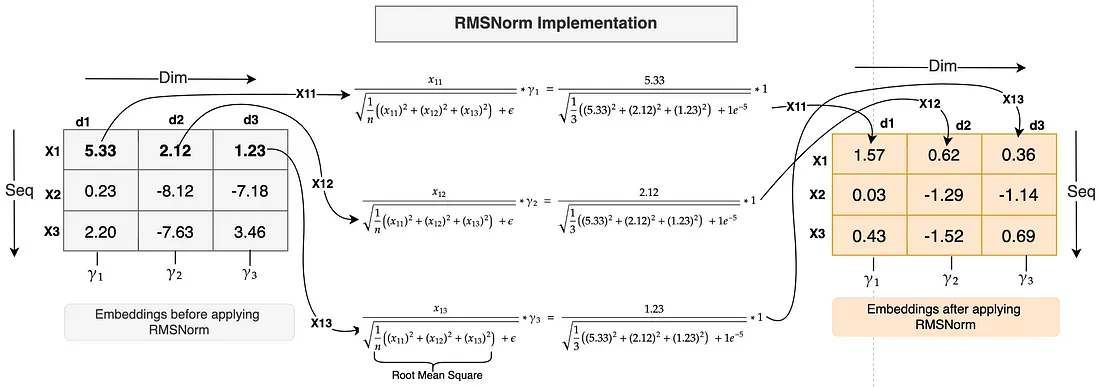

- Just like layer normalization, RMSNorm is applied along the embedding features or dimension.
- $\epsilon$ is a small constant to avoid division by Zero.
- $\gamma_i$ is a learnable parameter (initialized with 1) that is scaled up or down to bring further stability to the normalization.

**Why choose RMSNorm over layer normalization?** RMSNorm reduces the computational overhead by avoiding the calculation of mean and variance as layer normalization.

In [95]:
# Define parameters dataclass.
@dataclass
class ModelArgs:
    dim: int = 512               # embedding dimension
    n_layers: int = 8            # number of model decoder blocks
    n_heads: int = 8             # number of heads for queries embedding
    n_kv_heads: int = 4          # number of heads for keys and values embedding
    vocab_size: int = len(vocab) # Length of vocabulary
    multiple_of: int = 256       # Require to calculate dim of feedfoward network
    ffn_dim_multiplier: Optional[float] = None # Require to calculate dim of feedfoward network
    norm_eps: float = 1e-5                     # Default Epsilon value set for the RMSNorm calculation
    rope_theta: float = 10000.0  # Default theta value for the RoPE calculation

    max_batch_size: int = 10     # Max batch size
    max_seq_len: int = 256       # Max sequence length

    epochs: int = 50 #2500           # Total number of training iteration
    log_interval: int = 10       # Number of interval to print the logs and loss values   
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu' # Assign device to cuda or cpu based on availability 

In [96]:
class RMSNorm(nn.Module):
  def __init__(self, dim: int):
      super().__init__()
      device = ModelArgs.device
      self.eps = ModelArgs.norm_eps
      # gammas are initialized with one and the no of parameters is equal to the size of dim
      self.weight = nn.Parameter(torch.ones(dim).to(device))

  def _norm(self, x):
      return x * torch.rsqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps).to(device)

  def forward(self, x):
      #Shape: x[bs,seq,dim]
      output = self._norm(x.float()).type_as(x)

      #Shape: x[bs,seq,dim] -> x_norm[bs,seq,dim]
      return output * self.weight

In [97]:
### Test: RMSNorm Code ###
x = torch.randn((ModelArgs.max_batch_size, ModelArgs.max_seq_len, ModelArgs.dim), device=device)
rms_norm = RMSNorm(dim=ModelArgs.dim)
x_norm = rms_norm(x)

print(f"Shape of x: {x.shape}")
print(f"Shape of x_norm: {x_norm.shape}")

Shape of x: torch.Size([10, 256, 512])
Shape of x_norm: torch.Size([10, 256, 512])


## Rotary Positional Encoding (RoPE)

RoPE use `rotation matrix` to rotate a given embedding.

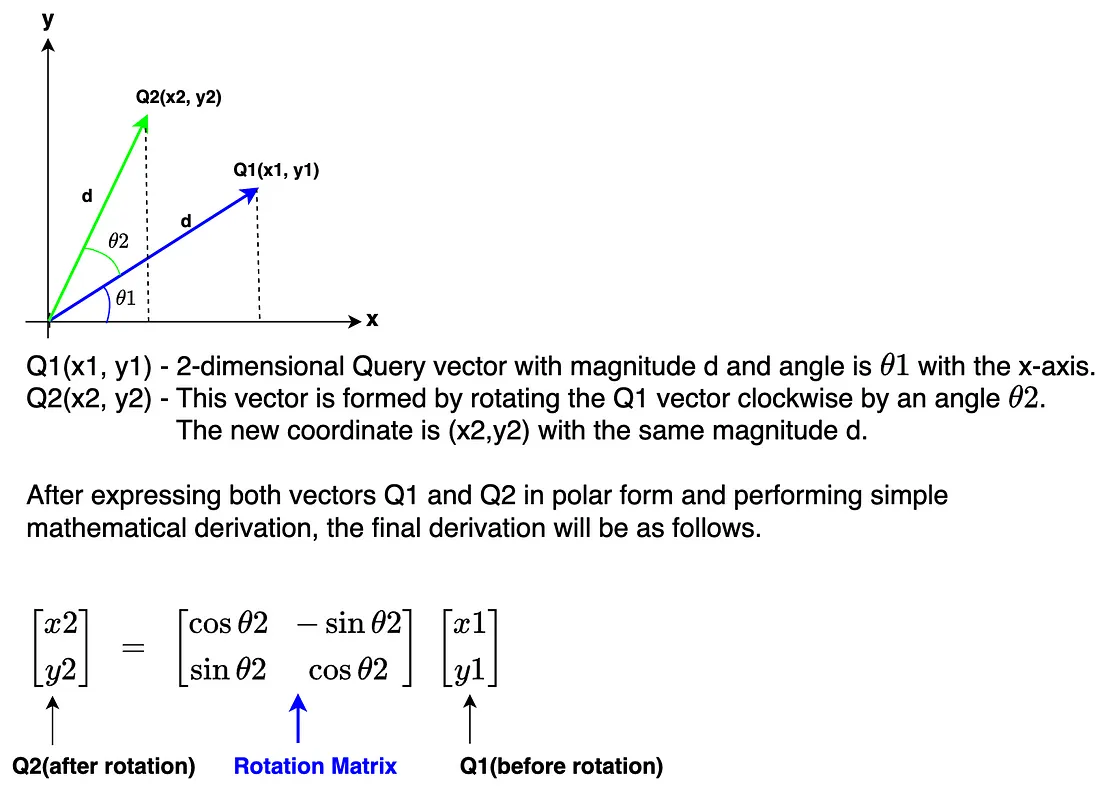

**How to apply rotation on higher-dimension embeddings.**

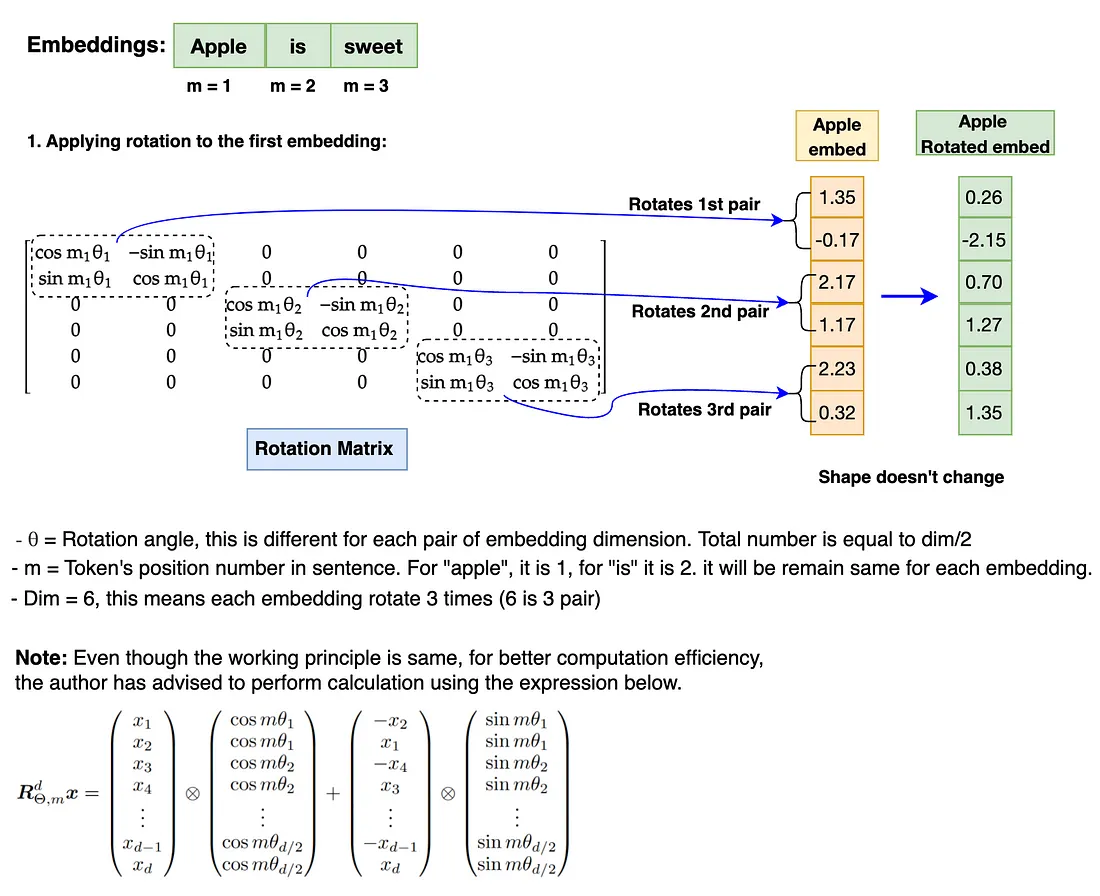

RoPE involves the multiplication of each embedding position (m) value and each pair of embedding dimensions $\theta$. This is how RoPE can capture `absolute position` as well as `relative position` information by the implementation of the `rotation matrix`.

**Note:** 
- Before rotation, the rotation matrix needs to be converted to polar form and the embedding vector needs converting to complex. 
- After rotation, the rotated embeddings need to be converted back to real. 
- RoPE is applied to Query and Key embedding only. It doesn’t apply to Value embedding.

In [98]:
def precompute_freqs_cis(dim:int, seq_len: int, theta: float=10000.0):
    # Computing Theta value for each dim pair which is dim/2
    device = ModelArgs.device
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2, device=device)[:(dim//2)].float()/dim))

    # Computing range of positions(m) in the sequence
    t = torch.arange(seq_len, dtype=torch.float32, device=device)

    # freqs gives all the Theta value range for all the position of tokens in the sequence
    freqs = torch.outer(t, freqs).to(device)

    # This is the rotation matrix which needs to be converted to Polar form in order to perform rotation to the embedding
    freqs_cis = torch.polar(torch.ones_like(freqs).to(device), freqs).to(device)
    return freqs_cis

def reshape_for_broadcast(freqs_cis, x):
    ndim = x.ndim
    assert 0<=1<ndim
    assert freqs_cis.shape == (x.shape[1],x.shape[-1]), "the last two dimension of freqs_cis, x must match"
    shape = [d if i==1 or i==ndim-1 else 1 for i,d in enumerate(x.shape)]
    return freqs_cis.view(*shape)

def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor)->Tuple[torch.Tensor, torch.Tensor]:
    device = ModelArgs.device
    # Applying rotary positional encoding to both query and key embedding together
    # First: The last dimension of xq and xk embedding needs to be reshaped to make it a pair. As rotation matrix is applied to each pair of dim.
    # Next: convert both xq and xk to complex number as the rotation matrix is only applicable to complex number
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2)).to(device)    #xq_:[bsz, seq_len, n_heads, head_dim/2]
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2)).to(device)    #xk_:[bsz, seq_len, n_heads, head_dim/2]

    # The rotation matrix(freqs_cis) dimensions across seq_len(dim=1) and head_dim(dim=3) should match with the embedding
    # Also, the shape freqs_cis should be the same with xq and xk, hence change the shape of freqs_cis:[seq_len,head_dim] -> freqs_cis:[1,seq_len,1,head_dim]
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)

    #Finally, perform rotation operation by multiplying with freqs_cis.
    #After the rotation is completed, convert both xq_out and xk_out back to real number and return
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3).to(device) #xq_out:[bsz, seq_len, n_heads, head_dim]
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3).to(device) #xk_out:[bsz, seq_len, n_heads, head_dim]
    return xq_out.type_as(xq), xk_out.type_as(xk)

In [99]:
### Test: RoPE Code ###
head_dim = ModelArgs.dim//ModelArgs.n_heads
wq = nn.Linear(ModelArgs.dim, ModelArgs.n_heads * head_dim, bias=False, device=device)
wk = nn.Linear(ModelArgs.dim, ModelArgs.n_kv_heads * head_dim, bias=False, device=device)
xq = wq(x_norm)
xk = wk(x_norm)
print(f"xq.shape: {xq.shape}")
print(f"xk.shape: {xk.shape}")

xq = xq.view(xq.shape[0],xq.shape[1],ModelArgs.n_heads, head_dim)
xk = xk.view(xk.shape[0],xk.shape[1],ModelArgs.n_kv_heads, head_dim)
print(f"xq.re-shape: {xq.shape}")
print(f"xk.re-shape: {xk.shape}")

freqs_cis = precompute_freqs_cis(dim=head_dim, seq_len=ModelArgs.max_seq_len)
print(f"freqs_cis.shape: {freqs_cis.shape}")

xq_rotate, xk_rotate = apply_rotary_emb(xq, xk, freqs_cis)
print(f"xq_rotate.shape: {xq_rotate.shape}")
print(f"xk_rotate.shape: {xk_rotate.shape}")

xq.shape: torch.Size([10, 256, 512])
xk.shape: torch.Size([10, 256, 256])
xq.re-shape: torch.Size([10, 256, 8, 64])
xk.re-shape: torch.Size([10, 256, 4, 64])
freqs_cis.shape: torch.Size([256, 32])
xq_rotate.shape: torch.Size([10, 256, 8, 64])
xk_rotate.shape: torch.Size([10, 256, 4, 64])


## KV Cache

`KV-Cache` (used for Inferencing) is to store previously generated tokens in the form of `Key` and `Value` cache. These caches will be used to calculate self-attention to generate the next token.

**Why do we need KV Cache?**

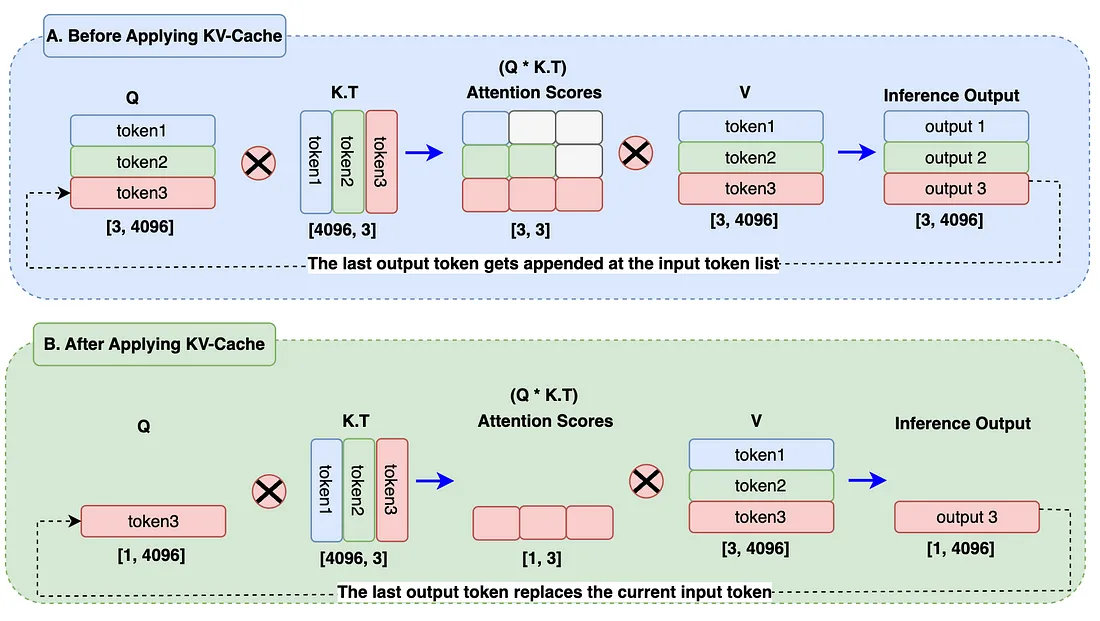

- **In the A block of the diagram**, when the output3 token is being generated, the previous output tokens (output1, output2) are still being calculated which is not necessary at all.

- **In block B of the diagram**, the output tokens replace the input token in Query embedding. KV-Cache stores the previously generated tokens. During attention score calculation, we will just have to use 1 token from the Query and use previous tokens from the KV-Cache. It reduces the matrix multiplication from 3x3 (block A) to 1x3 (block B), which is almost 66% reduction. Finally, there will always be only one latest output token generated.

## Group Query Attention

Group query attention is the Muilt-Head attention, but uses separate heads for queries and separate heads for keys/values. Usually, the number of heads assigned to queries is n-times to that of keys/values heads.

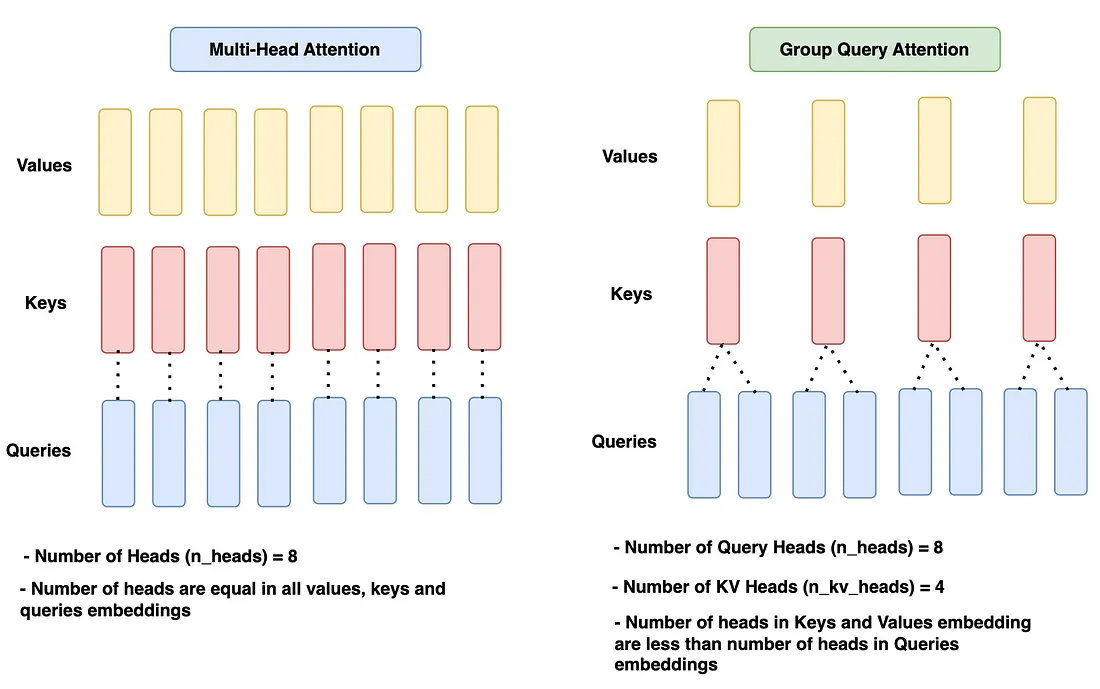

**Since MultiHead Attention is already so good, why do we need Group query attention?** 
- As `KV Cache` stores more and more previous tokens, the memory resources will increase significantly. This is not good for the model performance and the finance.
- `Group query attention` reduces the number of heads for K and V, decreases the number of parameters to be stored, and hence, less memory is being used. 

`Note:` Various test results have proven that the model accuracy remains in the same ranges with this approach.

In [100]:
## The Attention Block [The KV Cache; Group Query Attention]
## the naming convention follows original the meta's LLama3 GitHub

class Attention(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.args = args
        # Embedding dimension
        self.dim = args.dim
        # Number of heads assigned to Query
        self.n_heads = args.n_heads
        # Number of heads assigned to Key and values. If "None", the number will be same as Query.
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        # Dimension of each head relative to model dimension
        self.head_dim = args.dim // args.n_heads
        # Number of repetition in order to make time Key, Value heads to match Query heads number
        self.n_rep = args.n_heads // args.n_kv_heads

        # Weight initialize for Keys, Querys, Values and Oupt. Notice that the out_feature value of weight for q and kv are based on it's heads
        self.wq = nn.Linear(self.dim, self.n_heads * self.head_dim, bias=False, device=device)
        self.wk = nn.Linear(self.dim, self.n_kv_heads * self.head_dim, bias=False, device=device)
        self.wv = nn.Linear(self.dim, self.n_kv_heads * self.head_dim, bias=False, device=device)
        self.wo = nn.Linear(self.n_heads * self.head_dim, self.dim, bias=False, device=device)

        # Initialize caches to store Key, Values at start. (KV Cache Implementation)
        self.cache_k = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim), device=args.device)
        self.cache_v = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim), device=args.device)

    def forward(self, x: torch.Tensor, start_pos, inference):
        # Shape of the input embedding: [bsz,seq_len,dim]
        bsz, seq_len, _ = x.shape
        # Mask will be used during 'Training' and is not required for 'inference' due to the use of KV cache.
        mask = None

        xq = self.wq(x)  #x[bsz,seq_len,dim]*wq[dim,n_heads * head_dim] -> q[bsz,seq_len,n_heads * head_dim]
        xk = self.wk(x)  #x[bsz,seq_len,dim]*wq[dim,n_kv_heads * head_dim] -> k[bsz,seq_len,n_kv_heads * head_dim]
        xv = self.wv(x)  #x[bsz,seq_len,dim]*wq[dim,n_kv_heads * head_dim] -> v[bsz,seq_len,n_kv_heads * head_dim]

        # Reshaping Querys, Keys and Values by their number of heads. (Group Query Attention Implementation)
        xq = xq.view(bsz, seq_len, self.n_heads, self.head_dim)      #xq[bsz,seq_len,n_heads, head_dim]
        xk = xk.view(bsz, seq_len, self.n_kv_heads, self.head_dim)   #xk[bsz,seq_len,n_kv_heads, head_dim]
        xv = xv.view(bsz, seq_len, self.n_kv_heads, self.head_dim)   #xv[bsz,seq_len,n_kv_heads, head_dim]

        # Model - Inference Mode: kv-cache is enabled at inference mode only.
        if inference:
            # Compute rotation matrix for each position in the sequence
            freqs_cis = precompute_freqs_cis(dim=self.head_dim, seq_len=self.args.max_seq_len * 2)
            # During inferencing, we should only take the rotation matrix range from the current position of the tokens.
            freqs_cis = freqs_cis[start_pos : start_pos + seq_len]
            # Apply RoPE to Queries and Keys embeddings
            xq, xk = apply_rotary_emb(xq, xk, freqs_cis)

            self.cache_k = self.cache_k.to(xq)
            self.cache_v = self.cache_v.to(xq)
            # Store Keys and Values token embedding into their respective cache [KV Cache Implementation]
            self.cache_k[:bsz, start_pos:start_pos + seq_len] = xk
            self.cache_v[:bsz, start_pos:start_pos + seq_len] = xv

            # Assign all the previous tokens embeddings upto current tokens position to Keys and Values variable for Attention Calculation
            keys = self.cache_k[:bsz, :start_pos + seq_len]
            values = self.cache_v[:bsz, :start_pos + seq_len]

            # At this point, they Keys and Values shape aren't same with Queries Embedding which has to be in order to computer attention score
            # Use repeat_kv function to make Keys,Values shape same as queries shape
            keys = repeat_kv(keys, self.n_rep)      #keys[bsz,seq_len,n_heads,head_dim]
            values = repeat_kv(values, self.n_rep)  #values[bsz,seq_len,n_heads,head_dim]

        # Mode - Training mode: KV-Cache not implemented
        else:
            # Compute rotation matrix and apply RoPE to queries and keys for for training.
            freqs_cis = precompute_freqs_cis(dim=self.head_dim, seq_len=self.args.max_seq_len)

            #xq[bsz,seq_len,n_heads, head_dim], xk[bsz,seq_len,n_heads, head_dim]
            xq, xk = apply_rotary_emb(xq, xk, freqs_cis)

            # Use repeat_kv function to make Keys,Values shape same as the queries shape
            #keys[bsz,seq_len,n_heads,head_dim], #values[bsz,seq_len,n_heads,head_dim]
            keys = repeat_kv(xk, self.n_rep)
            values = repeat_kv(xv, self.n_rep)

            # For training mode, we'll compute mask and apply to the attention score later
            mask = torch.full((seq_len, seq_len),float("-inf"),device=self.args.device)
            mask = torch.triu(mask, diagonal=1).to(self.args.device)

        # To compute attention, we'll need to perform a transpose operation to reshape all queries, keys and values bring heads at dim 1 and seq at dim 2
        xq = xq.transpose(1,2)                  #xq[bsz,n_heads,seq_len,head_dim]
        keys = keys.transpose(1,2)              #keys[bsz,n_heads,seq_len,head_dim]
        values = values.transpose(1,2)          #values[bsz,n_heads,seq_len,head_dim]

        # Computing attention score
        scores = torch.matmul(xq, keys.transpose(2,3)).to(self.args.device)/math.sqrt(self.head_dim)
        if mask is not None:
            scores = scores + mask

        # Apply softmax to the attention score
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        # Matrix multiplication of attention score with the values
        output = torch.matmul(scores, values).to(self.args.device)

        # We get the contextual embedding for each head
        # All heads need to be reshaped back and combined to give a single single contextual attention output
        # Shape change: output[bsz,n_heads,seq_len,head_dim] -> output[bsz,seq_len, n_heads,head_dim] -> output[bsz,seq_len, n_heads * head_dim]
        output = output.transpose(1,2).contiguous().view(bsz, seq_len, -1)

        # shape: output [bsz,seq_len,dim]
        return self.wo(output)

# If the number of keys/values heads is less than query heads, this function expands the key/values embeddings with the required number of repetition
def repeat_kv(x:torch.Tensor, n_rep: int)-> torch.Tensor:
    bsz, seq_len, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:,:,:,None,:]
        .expand(bsz,seq_len,n_kv_heads,n_rep, head_dim)
        .reshape(bsz,seq_len,n_kv_heads * n_rep, head_dim)
    )


In [101]:
### Test: Repeat_kv function ###
n_rep = ModelArgs.n_heads // ModelArgs.n_kv_heads
keys = repeat_kv(xk, n_rep)
print(f"xk.shape: {xk.shape}")
print(f"keys.shape: {keys.shape}")

## Test: Attention function
attention = Attention(ModelArgs)
x_out = attention(x_norm,start_pos=0, inference=False)
print(f"x_out.shape: {x_out.shape}")

xk.shape: torch.Size([10, 256, 4, 64])
keys.shape: torch.Size([10, 256, 8, 64])
x_out.shape: torch.Size([10, 256, 512])


## FeedForward Network (SwiGLU Activation)

**What does FeedForward Network do in the decoder block?** Inside the feedforward network, the attention output embeddings will be expanded to the higher dimension throughout its hidden layers and learn more complex features of the tokens.

**Why use SwiGLU instead of ReLU?** The SwiGLU function behaves almost like ReLU in the positive axis. In the negative axis, SwiGLU outputs some negative values, which might be useful in learning smaller rather than flat 0 in the case of ReLU. In general, unlike ReLU, SwiGLU has derivatives at every point in $\mathbb{R}$.

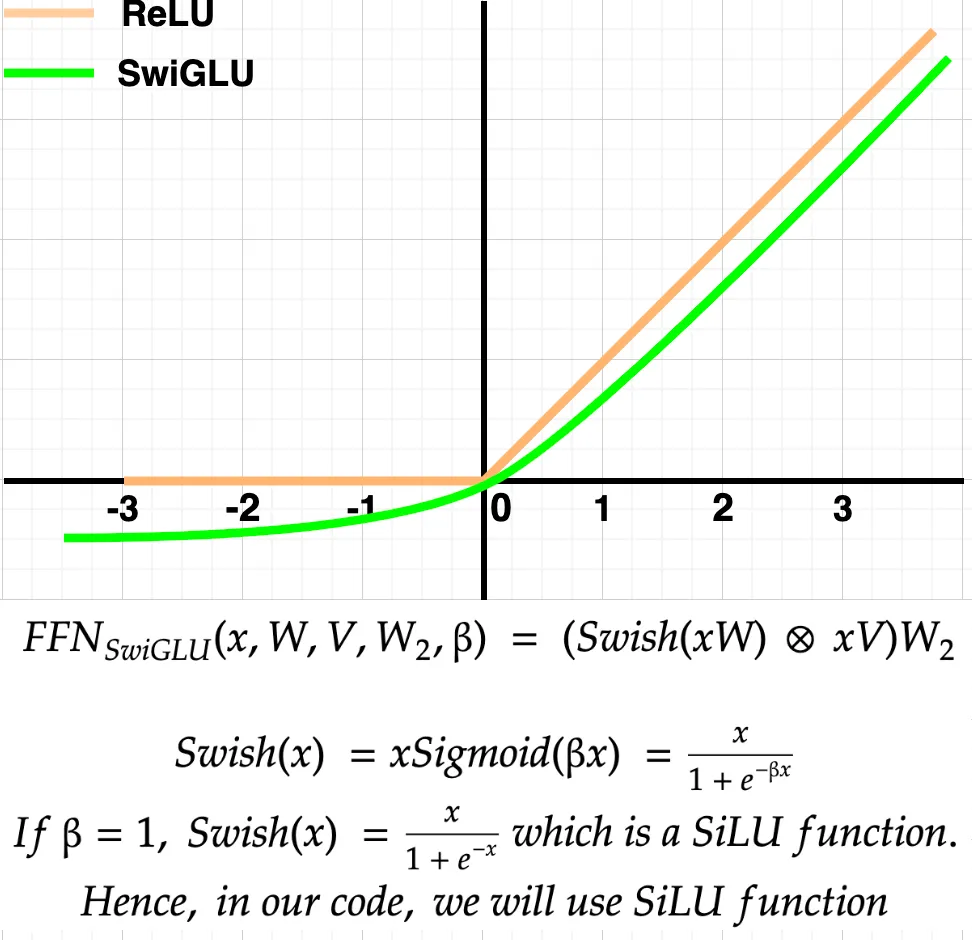

In [102]:
## The Feedfoward Network (SwiGLU activation)
class FeedForward(nn.Module):
    def __init__(self, dim:int, hidden_dim:int, multiple_of:int, ffn_dim_multiplier: Optional[float]):
        super().__init__()
        # Models embedding dimension
        self.dim = dim

        # We must use the hidden dimensions calculation shared by Meta which is the ideal one for this model
        # Hidden dimension are calculated such that it is a multiple of 256.
        hidden_dim = int(2 * hidden_dim/3)
        if ffn_dim_multiplier is not None:
            hidden_dim = int(ffn_dim_multiplier * hidden_dim)
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        # define hiddne layers weights
        self.w1 = nn.Linear(self.dim, hidden_dim, bias=False, device=device)
        self.w2 = nn.Linear(hidden_dim, self.dim, bias=False, device=device)
        self.w3 = nn.Linear(self.dim, hidden_dim, bias=False, device=device)

    def forward(self, x):
        # Shape: [bsz,seq_len,dim]
        return self.w2(F.silu(self.w1(x)) * self.w3(x))

In [103]:
### Test: FeedForward module ###
feed_forward = FeedForward(ModelArgs.dim, 4 * ModelArgs.dim, ModelArgs.multiple_of, ModelArgs.ffn_dim_multiplier)
x_out = rms_norm(x_out)
x_out = feed_forward(x_out)
print(f"feed forward output: x_out.shape: {x_out.shape}")

feed forward output: x_out.shape: torch.Size([10, 256, 512])


## Decoder Block

Pointwise operation inside the decoder block shown in the architecture.

In [104]:
## The Decoder Block.
class TransformerBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.args = args
        # Initilizate RMSNorm for attention
        self.attention_norm = RMSNorm(dim=args.dim)
        # Initilizate Attention class
        self.attention = Attention(args)
        # Initilizate RMSNorm for feedfoward class
        self.ff_norm = RMSNorm(dim=args.dim)
        # Initilizate feedfoward class
        self.feedforward = FeedForward(args.dim, 4 * args.dim, args.multiple_of, args.ffn_dim_multiplier)

    def forward(self, x, start_pos, inference):
        # start_pos = token position for inference mode, inference = True for inference and False for training mode
        # i) pass input embedding to attention_norm and then pass to attention block.
        # ii) the output of attention is then added to embedding(before norm)
        h = x + self.attention(self.attention_norm(x), start_pos, inference)

        # i) pass attention output to ff_norm and then pass to the feedforward network.
        # ii) the output of feedforward network is then added to the attention output(before ff_norm)
        out = h + self.feedforward(self.ff_norm(h))
        # Shape: [bsz,seq_len,dim]
        return out

In [105]:
### Test: TransformerBlock ###
x = torch.randn((ModelArgs.max_batch_size, ModelArgs.max_seq_len, ModelArgs.dim), device=device)
transformer_block = TransformerBlock(ModelArgs)
transformer_block_out = transformer_block(x,start_pos=0, inference=False)
print(f"transformer_block_out.shape: {transformer_block_out.shape}")

transformer_block_out.shape: torch.Size([10, 256, 512])


# The Output Block

The decoder output goes through blocks shown in the architecture. One of the following two operations happens.

- **inference** mode: top_p probability is calculated and the next token is generated. The next tokens generated will stop if the max generation length is reached or the end of sentence token is generated as the next token.
- **training** mode: loss is computed with the target labels and training is repeated till the max epochs length is reached.

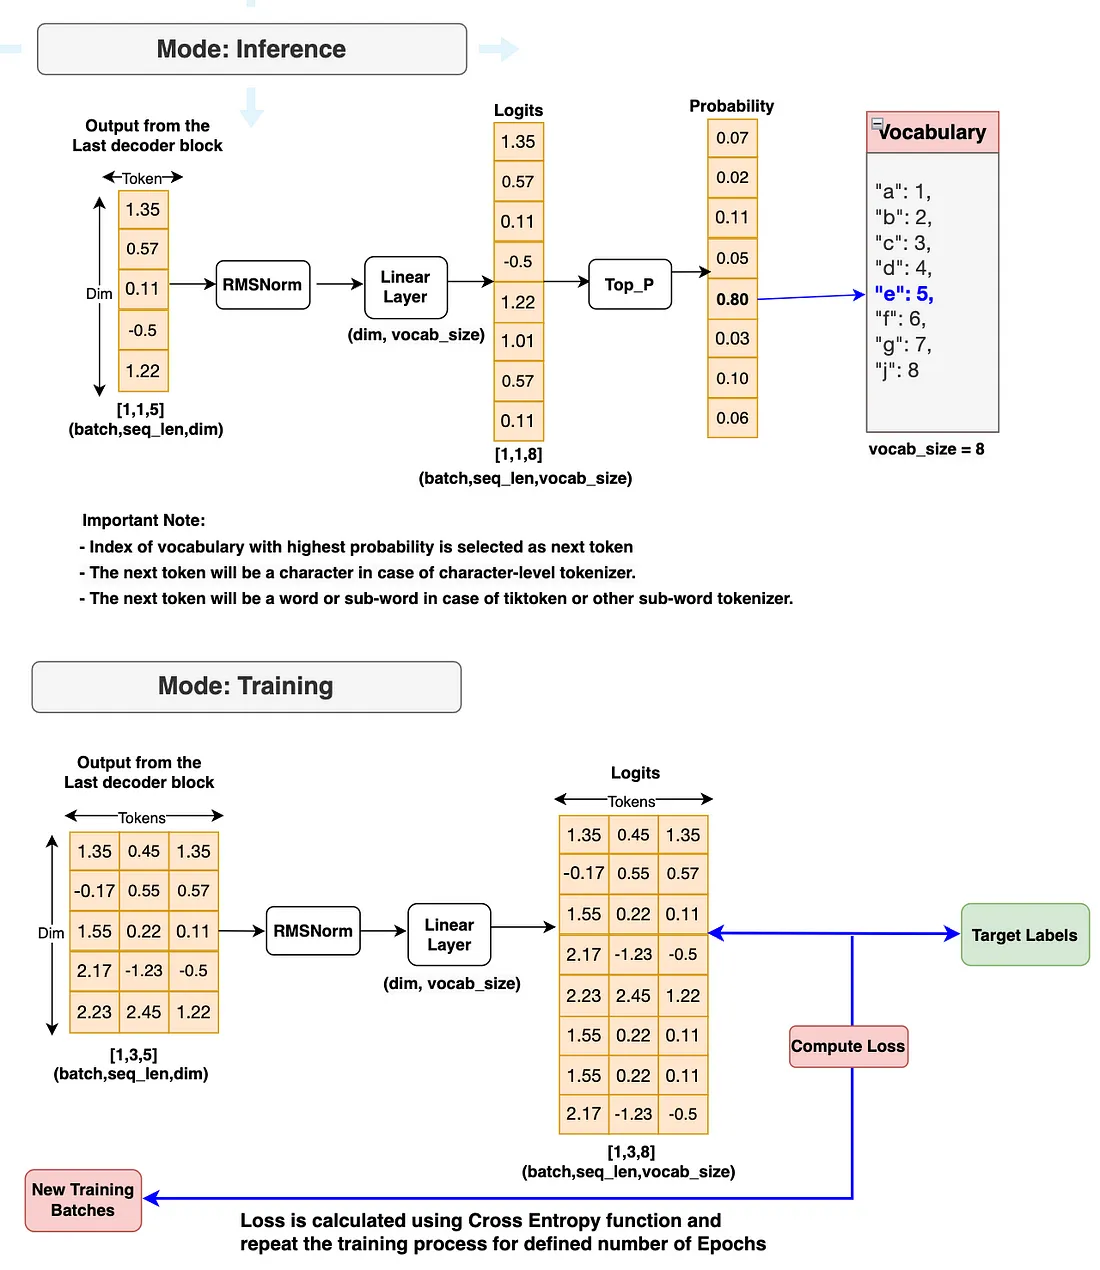

Finally, combine all components of 3 blocks: input block, decoder block and output blocks to give final Llama 3 model.

In [106]:
## The Output Block
# This is the Llama 3 model.
class Transformer(nn.Module):
    def __init__(self, params: ModelArgs):
        super().__init__()
        # set all the ModelArgs in params variable
        self.params = params
        # Initilizate embedding class from the input block
        self.tok_embeddings = nn.Embedding(params.vocab_size, params.dim)

        # Initialize the decoder block and store it inside the ModuleList. 
        # This is because we've 4 decoder blocks in our Llama 3 model. (Official Llama 3 has 32 blocks)
        self.layers = nn.ModuleList()
        for layer_id in range(params.n_layers):
            self.layers.append(TransformerBlock(args=params))

        # Initilizate RMSNorm for the output block
        self.norm = RMSNorm(params.dim)
        
        # Initilizate linear layer at the output block.
        self.output = nn.Linear(params.dim, params.vocab_size, bias=False)

    def forward(self, x, start_pos=0, targets=None):
        # start_pos = token position for inference mode, inference = True for inference and False for training mode
        # x is the batch of token_ids generated from the texts or prompts using tokenizers.
        # x[bsz, seq_len] -> h[bsz, seq_len, dim]
        h = self.tok_embeddings(x)

        # If the target is none, Inference mode is activated and set to "True" and "False" if Training mode is activated.
        if targets is None:
            inference = True
        else:
            inference = False

        # The embeddings (h) will then pass though all the decoder blocks.
        for layer in self.layers:
            h = layer(h, start_pos, inference)

        # The output from the final decoder block will feed into the RMSNorm
        h = self.norm(h)

        # After normalized, the embedding h will then feed into the Linear layer. 
        # The main task of the Linear layer is to generate logits that maps the embeddings with the vocabulary size.
        # h[bsz, seq_len, dim] -> logits[bsz, seq_len, vocab_size]
        logits = self.output(h).float()
        loss = None

        # Inference mode is activated if the targets is not available
        if targets is None:
            loss = None
        # Training mode is activated if the targets are available. And Loss will be calculated for further model training. 
        else:
            loss = F.cross_entropy(logits.view(-1, self.params.vocab_size), targets.view(-1))

        return logits, loss

In [107]:
### Test: Transformer (Llama Model) ###
model = Transformer(ModelArgs).to(ModelArgs.device)
print(model)

Transformer(
  (tok_embeddings): Embedding(12003, 512)
  (layers): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attention_norm): RMSNorm()
      (attention): Attention(
        (wq): Linear(in_features=512, out_features=512, bias=False)
        (wk): Linear(in_features=512, out_features=256, bias=False)
        (wv): Linear(in_features=512, out_features=256, bias=False)
        (wo): Linear(in_features=512, out_features=512, bias=False)
      )
      (ff_norm): RMSNorm()
      (feedforward): FeedForward(
        (w1): Linear(in_features=512, out_features=1536, bias=False)
        (w2): Linear(in_features=1536, out_features=512, bias=False)
        (w3): Linear(in_features=512, out_features=1536, bias=False)
      )
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=512, out_features=12003, bias=False)
)


# Training

In [108]:
# Create a dataset by encoding the entire tiny_shakespeare data token_ids list using the tokenizer's encode function that we've built at the input block section
dataset = torch.tensor(encode(data), dtype=torch.int).to(ModelArgs.device)
print(f"dataset-shape: {dataset.shape}")

# Define function to generate batches from the given dataset
def get_dataset_batch(data, split, args:ModelArgs):
    seq_len = args.max_seq_len
    batch_size = args.max_batch_size
    device = args.device

    train = data[:int(0.8 * len(data))]
    val = data[int(0.8 * len(data)): int(0.9 * len(data))]
    test = data[int(0.9 * len(data)):]

    batch_data = train
    if split == "val":
        batch_data = val

    if split == "test":
        batch_data = test
    
    # Picking random starting points from the dataset to give random samples for training, validation and testing.
    ix = torch.randint(0, len(batch_data) - seq_len - 3, (batch_size,)).to(device)
    x = torch.stack([torch.cat([token_bos, batch_data[i:i+seq_len-1]]) for i in ix]).long().to(device)
    y = torch.stack([torch.cat([batch_data[i+1:i+seq_len], token_eos]) for i in ix]).long().to(device)
    
    return x,y

dataset-shape: torch.Size([1115394])


In [109]:
### Test: get_dataset function ###
xs, ys = get_dataset_batch(dataset, split="train", args=ModelArgs)
print([(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))])

[('<|begin_of_text|> hie, make haste,\nMake haste; the bridegroom he is come already:\nMake haste, I say.\n\nNurse:\nMistress! what, mistress! Juliet! fast, I warrant her, she:\nWhy, lamb! why, lady! fie, you slug-a-bed!\nWhy, love, I say! madam! sweet-heart! why, bride!\nWhat, not ', 'hie, make haste,\nMake haste; the bridegroom he is come already:\nMake haste, I say.\n\nNurse:\nMistress! what, mistress! Juliet! fast, I warrant her, she:\nWhy, lamb! why, lady! fie, you slug-a-bed!\nWhy, love, I say! madam! sweet-heart! why, bride!\nWhat, not a<|end_of_text|>'), ("<|begin_of_text|>To say 'King Richard:' alack the heavy day\nWhen such a sacred king should hide his head.\n\nNORTHUMBERLAND:\nYour grace mistakes; only to be brief\nLeft I his title out.\n\nDUKE OF YORK:\nThe time hath been,\nWould you have been so brief with him, he would\nHave b", "o say 'King Richard:' alack the heavy day\nWhen such a sacred king should hide his head.\n\nNORTHUMBERLAND:\nYour grace mistakes; only to be br

In [110]:
# Define a evaluate loss function to calculate and store training and validation loss for logging and plotting
@torch.no_grad()
def evaluate_loss(model, args:ModelArgs):
    out = {}
    model.eval()

    for split in ["train", "val"]:
        losses = []
        for _ in range(10):      
            xb, yb = get_dataset_batch(dataset, split, args)
            _, loss = model(x=xb, targets=yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)

    model.train()
    return out

# Define a training function to perform model training
def train(model, optimizer, args:ModelArgs):
    epochs = args.epochs
    log_interval = args.log_interval
    device = args.device
    losses = []   
    start_time = time.time()

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        xs, ys = get_dataset_batch(dataset, 'train', args)
        xs = xs.to(device)
        ys = ys.to(device)
        logits, loss = model(x=xs, targets=ys)
        loss.backward()
        optimizer.step()

        if epoch % log_interval == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model, args)
            losses += [x]            
            print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f}")
            start_time = time.time()
    
    # Print the final validation loss
    print("validation loss: ", losses[-1]['val'])
    # Display the interval losses in plot 
    return pd.DataFrame(losses).plot()

Epoch 0 | val loss 7.309 | Time 4.639
Epoch 10 | val loss 3.228 | Time 38.361
Epoch 20 | val loss 3.108 | Time 51.933
Epoch 30 | val loss 3.005 | Time 49.360
Epoch 40 | val loss 2.961 | Time 50.793
validation loss:  2.9610998153686525


<Axes: >

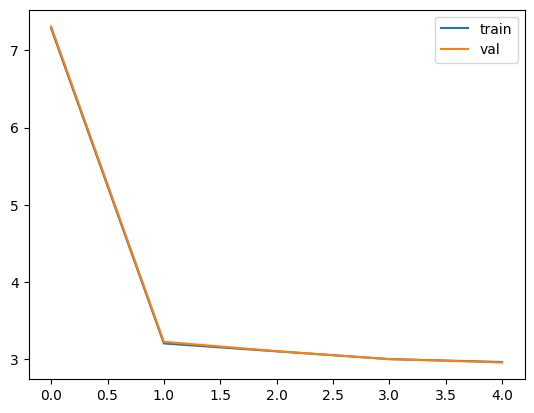

In [111]:
## Start training our Llama 3 model
model = Transformer(ModelArgs).to(ModelArgs.device)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, ModelArgs)

# Inference

In [112]:
# This function generates text sequences based on provided prompts.

def generate(model, prompts: str, params: ModelArgs, max_gen_len: int=500, temperature: float = 0.6, top_p: float = 0.9):
    # prompt_tokens: List of user input texts or prompts
    # max_gen_len: Maximum length of the generated text sequence.
    # temperature: Temperature value for controlling randomness in sampling. Defaults to 0.6.
    # top_p: Top-p probability threshold for sampling prob output from the logits. Defaults to 0.9.
    # prompt_tokens = [0]
    bsz = 1  #For inferencing, in general user just input one prompt which we'll take it as 1-batch
    prompt_tokens = token_bos.tolist() + encode(prompts)
    assert len(prompt_tokens) <= params.max_seq_len, "prompt token length should be small than max_seq_len"
    total_len = min(len(prompt_tokens)+max_gen_len, params.max_seq_len)   

    # this tokens matrix is to store the input prompts and all the output that is generated by model.
    # later we'll use the tokenizers decode function to decode this token to view results in text format
    tokens = torch.full((bsz,total_len), fill_value=token_pad.item(), dtype=torch.long, device=params.device)

    # fill in the prompt tokens into the token matrix
    tokens[:,:len(prompt_tokens)] = torch.tensor(prompt_tokens, dtype=torch.long, device=params.device)

    #create a prompt_mask_token for later use to identify if the token is a prompt token or a padding token
    # True if it is a prompt token, False if it is a padding token
    input_text_mask = tokens != token_pad.item()

    #now we can start inferencing using one token at a time from the prompt_tokens list starting with the first position.
    prev_pos = 0
    for cur_pos in range(1, total_len):
      with torch.no_grad():
        logits, _ = model(x=tokens[:,prev_pos:cur_pos], start_pos=prev_pos)
      if temperature > 0:      
        probs = torch.softmax(logits[:, -1]/temperature, dim=-1)
        next_token = sample_top_p(probs, top_p)        
      else:
        next_token = torch.argmax(logits[:, -1], dim=-1)        

      next_token = next_token.reshape(-1)

      # only replace the token if it's a padding token
      next_token = torch.where(input_text_mask[:, cur_pos], tokens[:, cur_pos], next_token)
      tokens[:, cur_pos] = next_token

      prev_pos = cur_pos
      if tokens[:,cur_pos]==token_pad.item() and next_token == token_eos.item():
        break

    output_tokens, output_texts = [], []    

    for i, toks in enumerate(tokens.tolist()):
      # eos_idx = toks.index(token_eos.item())
      if token_eos.item() in toks:
        eos_idx = toks.index(token_eos.item())
        toks = toks[:eos_idx]

      output_tokens.append(toks)
      output_texts.append(decode(toks))
    return output_tokens, output_texts

# Perform top-p (nucleus) sampling on a probability distribution.
# probs (torch.Tensor): Probability distribution tensor derived from the logits.
# p: Probability threshold for top-p sampling.
# According to the paper, Top-p sampling selects the smallest set of tokens whose cumulative probability mass exceeds the threshold p. 
# The distribution is renormalized based on the selected tokens.
def sample_top_p(probs, p):
    probs_sort, prob_idx = torch.sort(probs, dim=-1, descending=True)
    probs_sum = torch.cumsum(probs_sort, dim=-1)
    mask = probs_sum - probs_sort > p
    probs_sort[mask] = 0.0
    probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
    next_token = torch.multinomial(probs_sort, num_samples=1)
    next_token = torch.gather(prob_idx, -1, next_token)    
    # Sampled token indices from the vocabular is returned 
    return next_token

In [113]:
## Perform the inferencing on user input prompts
prompts = "Consider you what services he has done"
output_tokens, output_texts = generate(model, prompts, ModelArgs)
output_texts = output_texts[0].replace("<|begin_of_text|>", "")
print(output_texts)

Consider you what services he has done oe o e hs o oe,at ad aes i o o o e
n oe hrih e eo o o eti u ae,Teteto aee o ad eaeted
n o o oe al a a osoei o o o h oe o u i als h htea iea ostn h hsti ee h e orwlot ot
oedieal o hat o ae odn o eetet e ht h od oee o 


`Note:` the output does not seem great given the amount of training data and epochs. 

# Reference
[Build Your Own Llama 3 Architecture from Scratch Using PyTorch](https://pub.towardsai.net/build-your-own-llama-3-architecture-from-scratch-using-pytorch-2ce1ecaa901c)

[Building LLaMA 3 From Scratch with Python](https://levelup.gitconnected.com/building-llama-3-from-scratch-with-python-e0cf4dbbc306)